In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
from ipywidgets import interact, IntSlider, Checkbox

# === Load video frames ===
video_path = "/Users/juicejambouree/test2/swim_data/swarming_proteus.mp4"
cap = cv2.VideoCapture(video_path)

frames = []
frame_count = 0
max_frames = 100
while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)
    frames.append(gray)
    frame_count += 1
cap.release()

if len(frames) == 0:
    raise RuntimeError("No frames could be read from the video.")

stack = np.stack(frames)
avg_frame = np.mean(stack, axis=0)
first_subtracted = stack[0] - avg_frame

# === Merge nearby detections ===
def merge_rods_by_shape(df, merge_dist=10, max_rod_length=30, max_aspect_ratio=5):
    """
    Merge nearby detections into rod-like objects using clustering and PCA.
    
    Parameters:
        df: DataFrame with columns 'x' and 'y'
        merge_dist: clustering distance (pixels)
        max_rod_length: maximum distance allowed within a single rod (pixels)
        max_aspect_ratio: how elongated a cluster must be to be merged into a rod

    Returns:
        Merged DataFrame with one point per rod
    """
    from sklearn.cluster import DBSCAN
    from sklearn.decomposition import PCA

    coords = df[['x', 'y']].values
    if len(coords) == 0:
        return df
    
    # Cluster points that are spatially close
    db = DBSCAN(eps=merge_dist, min_samples=1).fit(coords)
    df['cluster'] = db.labels_
    
    merged_rows = []

    for label in np.unique(db.labels_):
        cluster_pts = coords[db.labels_ == label]
        if len(cluster_pts) == 1:
            merged_rows.append({'x': cluster_pts[0][0], 'y': cluster_pts[0][1]})
            continue

        # PCA to analyze shape of cluster
        pca = PCA(n_components=2)
        pca.fit(cluster_pts)
        length = np.sqrt(pca.explained_variance_[0])
        width = np.sqrt(pca.explained_variance_[1])
        aspect = length / (width + 1e-6)

        if aspect > max_aspect_ratio and length * 2 < max_rod_length:
            # It's rod-like: average the full cluster
            merged_x, merged_y = np.mean(cluster_pts, axis=0)
        else:
            # It's not rod-like: treat each point as individual
            for pt in cluster_pts:
                merged_rows.append({'x': pt[0], 'y': pt[1]})
            continue

        merged_rows.append({'x': merged_x, 'y': merged_y})

    return pd.DataFrame(merged_rows)


# === Interactive parameter test ===
def show_detection(minmass=15, diameter=7, consolidate_rods=True, merge_dist=7):
    plt.figure(figsize=(8, 8))
    plt.imshow(first_subtracted, cmap='gray')
    
    detected = tp.locate(first_subtracted, diameter=diameter, minmass=minmass,
                         separation=5, invert=True)
    
    if detected is not None and len(detected) > 0:
        if consolidate_rods:
            detected = merge_nearby_points(detected, merge_dist)
        plt.scatter(detected['x'], detected['y'], s=50, c='none', edgecolors='lime', label='Detected')
        plt.legend()
    
    plt.title(f"minmass={minmass}, diameter={diameter}, consolidate_rods={consolidate_rods}")
    plt.axis('off')
    plt.show()

# === Interactive sliders ===
interact(show_detection,
         minmass=IntSlider(min=1, max=50, step=1, value=15),
         diameter=IntSlider(min=3, max=15, step=2, value=7),
         consolidate_rods=Checkbox(value=True),
         merge_dist=IntSlider(min=1, max=20, step=1, value=7))


interactive(children=(IntSlider(value=15, description='minmass', max=50, min=1), IntSlider(value=7, descriptio…

<function __main__.show_detection(minmass=15, diameter=7, consolidate_rods=True, merge_dist=7)>

In [10]:
import os
import pickle
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trackpy as tp
import tifffile as tiff
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

def merge_rods_by_shape(df, merge_dist=10, max_rod_length=30, max_aspect_ratio=5):
    coords = df[['x', 'y']].values
    if len(coords) == 0:
        return df

    db = DBSCAN(eps=merge_dist, min_samples=1).fit(coords)
    df['cluster'] = db.labels_
    merged_rows = []

    for label in np.unique(db.labels_):
        cluster_pts = coords[db.labels_ == label]
        if len(cluster_pts) == 1:
            merged_rows.append({'x': cluster_pts[0][0], 'y': cluster_pts[0][1]})
            continue

        pca = PCA(n_components=2)
        pca.fit(cluster_pts)
        length = np.sqrt(pca.explained_variance_[0])
        width = np.sqrt(pca.explained_variance_[1])
        aspect = length / (width + 1e-6)

        if aspect > max_aspect_ratio and length * 2 < max_rod_length:
            merged_x, merged_y = np.mean(cluster_pts, axis=0)
        else:
            for pt in cluster_pts:
                merged_rows.append({'x': pt[0], 'y': pt[1]})
            continue

        merged_rows.append({'x': merged_x, 'y': merged_y})

    return pd.DataFrame(merged_rows)

def run_tracking_pipeline(
    input_media,
    output_tiff,
    param_file='tracking_params.pkl',
    show_plot=True,
    param_overrides=None,
    mode='swimming',
    rolling_bg=False,
    rod_shaped=False
):
    default_modes = {
        'swimming': {'chunk_size': 500, 'diameter': 7, 'minmass': 15, 'search_range': 11, 'memory': 7, 'stub_threshold': 5, 'invert': False},
        'twitching': {'chunk_size': 300, 'diameter': 5, 'minmass': 5, 'search_range': 4, 'memory': 1, 'stub_threshold': 2, 'invert': False},
        'biofilm': {'chunk_size': 300, 'diameter': 4, 'minmass': 3, 'search_range': 2, 'memory': 0, 'stub_threshold': 1, 'invert': False},
        'swarming': {'chunk_size': 500, 'diameter': 9, 'minmass': 10, 'search_range': 20, 'memory': 10, 'stub_threshold': 10, 'invert': False},
        'gliding': {'chunk_size': 500, 'diameter': 6, 'minmass': 5, 'search_range': 3, 'memory': 5, 'stub_threshold': 4, 'invert': False},
        'pili_retraction': {'chunk_size': 400, 'diameter': 5, 'minmass': 4, 'search_range': 6, 'memory': 2, 'stub_threshold': 2, 'invert': False},
    }

    if mode not in default_modes:
        raise ValueError(f"Unknown mode '{mode}'. Choose from: {', '.join(default_modes.keys())}.")

    if os.path.exists(param_file):
        with open(param_file, 'rb') as f:
            params = pickle.load(f)
        print(f"Loaded parameters from {param_file}.")
    else:
        params = default_modes[mode].copy()
        print(f"Using default parameters for mode '{mode}'.")

    if param_overrides:
        for key, val in param_overrides.items():
            if key in params:
                params[key] = val
                print(f"Override: {key} = {val}")
            else:
                print(f"Warning: Unknown parameter '{key}' ignored.")

    with open(param_file, 'wb') as f:
        pickle.dump(params, f)
        print(f"Parameters saved to {param_file}.")

    print("Final tracking parameters:")
    for key, val in params.items():
        print(f"  {key}: {val}")

    if os.path.exists(output_tiff):
        print(f"TIFF found at {output_tiff}. Loading...")
        stack_reader = lambda s, e: tiff.imread(output_tiff, key=range(s, e)).astype(np.float32)
        with tiff.TiffFile(output_tiff) as tif:
            n_frames = len(tif.pages)
    else:
        print(f"Reading video {input_media} into memory...")
        cap = cv2.VideoCapture(input_media)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(gray.astype(np.float32))
        cap.release()

        full_stack = np.stack(frames)
        n_frames = full_stack.shape[0]
        print(f"Loaded {n_frames} frames.")
        stack_reader = lambda s, e: full_stack[s:e]

    print("Preparing background subtraction...")
    if rolling_bg:
        print("Using rolling background subtraction.")
    else:
        bg_sample = stack_reader(0, min(100, n_frames))
        avg_frame = np.mean(bg_sample, axis=0)

    features = []
    for start in range(0, n_frames, params['chunk_size']):
        end = min(start + params['chunk_size'], n_frames)
        print(f"Processing frames {start} to {end - 1}...")

        chunk = stack_reader(start, end)
        for i, frame in enumerate(chunk, start=start):
            if rolling_bg:
                win_start = max(0, i - 5)
                win_end = min(n_frames, i + 5)
                local_bg = np.mean(stack_reader(win_start, win_end), axis=0)
                subtracted = frame - local_bg
            else:
                subtracted = frame - avg_frame

            if np.max(subtracted) == 0:
                continue

            f = tp.locate(subtracted, diameter=params['diameter'],
                          minmass=params['minmass'], invert=params['invert'])
            if f is not None and len(f) > 0:
                if rod_shaped:
                    f = merge_rods_by_shape(f, merge_dist=7, max_rod_length=30, max_aspect_ratio=4)
                f['frame'] = i
                features.append(f)

    if features:
        f_all = pd.concat(features, ignore_index=True)
        print(f"Detected {len(f_all)} features.")

        t = tp.link_df(f_all, search_range=params['search_range'], memory=params['memory'])
        t_filtered = tp.filter_stubs(t, threshold=params['stub_threshold'])

        print(f"Final trajectory count: {t_filtered['particle'].nunique()}")

        if show_plot:
            tp.plot_traj(t_filtered)
            plt.show()

        return t_filtered
    else:
        print("No features detected.")
        return None


Frame 500: 395 trajectories present.
Final trajectory count: 1716


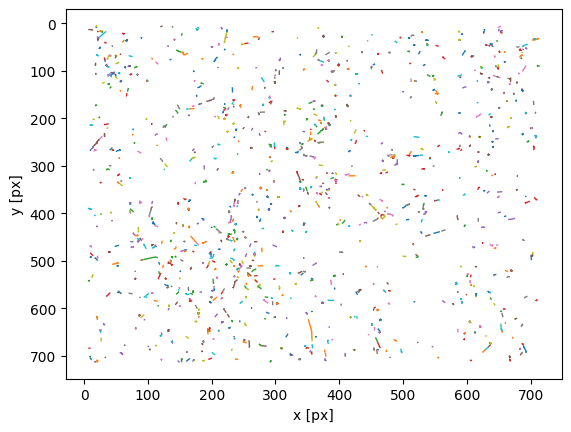

In [14]:
t_filtered = run_tracking_pipeline(
    input_media="/Users/juicejambouree/test2/swim_data/swarming_proteus.mp4",
    output_tiff="swarming_output.tif",
    mode="swarming",
    rolling_bg=False,
    rod_shaped=True,
    param_overrides={'search_range':2, 'diameter':15, 'minmass':50, 'invert':True}
)

In [30]:
# === Load Parameters from Pickle ===
from shapely.geometry import LineString
import pickle
import numpy as np

param_file = 'params.pkl'

default_params = {
    # For all types
    'frame_interval': 0.05,
    'min_circle_dt': 0.5,
    'max_circle_dt': 20.0,
    'circle_cost_threshold': 0.6,
    'fracCircling_threshold': 0.1,
    'twitch_jump_threshold': 5.0,
    'biofilm_disp_threshold': 3.0,
    'glide_angle_threshold': 0.1,
    'swarm_density_threshold': 3,
    'pili_retract_burst_threshold': 8.0
}

try:
    with open(param_file, 'rb') as f:
        params = pickle.load(f)
    print(f"Loaded parameters from {param_file}")
except FileNotFoundError:
    params = default_params
    with open(param_file, 'wb') as f:
        pickle.dump(params, f)
    print(f"Created default parameter file: {param_file}")


# === Build Trajectory List from t_filtered ===
traj = []
for particle, group in t_filtered.groupby('particle'):
    traj.append({
        'particle': particle,
        'x': group['x'].values,
        'y': group['y'].values,
        'time': (group['frame'].values - group['frame'].values[0]) * params['frame_interval'],
        'dt': np.array([params['frame_interval']])
    })

def detect_motility(
    traj, params,
    peri=False, mono=False,
    twitch=False, biofilm=False,
    gliding=False, swarming=False, pili_retracting=False,
    reversal_angle_threshold=np.pi * 5/6,
    twitch_jump_threshold=5.0,
    biofilm_disp_threshold=3.0,
    glide_angle_threshold=0.1,
    swarm_density_threshold=3,
    pili_retract_burst_threshold=8.0
):
    """
    Annotates trajectory data with motility features.
    Supports multiple bacterial motility types.
    """

    if peri:
        for traj_i in traj:
            t = traj_i['time']
            dt = traj_i['dt']

            if len(t) < params['min_circle_dt'] / dt:
                continue

            x = np.array(traj_i['x']) - np.nanmean(traj_i['x'])
            y = np.array(traj_i['y']) - np.nanmean(traj_i['y'])
            coords = list(zip(x, y))

            intersections = []
            for i in range(len(coords) - 1):
                seg1 = LineString([coords[i], coords[i+1]])
                for j in range(i+2, len(coords) - 1):
                    seg2 = LineString([coords[j], coords[j+1]])
                    if seg1.crosses(seg2):
                        pt = seg1.intersection(seg2)
                        intersections.append((pt.x, pt.y))

            t1, t2 = [], []
            for px, py in intersections:
                distances = np.abs(x - px) + np.abs(y - py)
                idx1 = np.argmin(distances)
                t1.append(idx1)

                mask = np.ones_like(x, dtype=bool)
                r1, r2 = max(0, idx1 - 3), min(len(x), idx1 + 4)
                mask[r1:r2] = False

                x2, y2 = np.copy(x), np.copy(y)
                x2[~mask], y2[~mask] = np.inf, np.inf

                distances2 = np.abs(x2 - px) + np.abs(y2 - py)
                idx2 = np.argmin(distances2)
                t2.append(idx2)

            t1, t2 = np.array(t1), np.array(t2)
            loop_durations = (t2 - t1 + 1) * dt
            valid_loops = (loop_durations >= params['min_circle_dt']) & (loop_durations <= params['max_circle_dt'])
            t1, t2 = t1[valid_loops], t2[valid_loops]

            costs = np.empty(len(t1))
            for j in range(len(t1)):
                seg_x = x[t1[j]:t2[j]+1]
                seg_y = y[t1[j]:t2[j]+1]
                c = [np.nanmean(seg_x), np.nanmean(seg_y)]
                rs = np.sqrt((seg_x - c[0])**2 + (seg_y - c[1])**2)
                r = np.nanmean(rs)
                costs[j] = (1 / r) * np.max(np.abs(r - rs))

            circles = costs < params['circle_cost_threshold']
            circling_mask = np.zeros(len(x), dtype=bool)
            for j in range(len(t1)):
                if circles[j]:
                    circling_mask[t1[j]:t2[j]+1] = True

            frac_circling = np.sum(circling_mask) / len(x)
            traj_i['circling'] = circling_mask if frac_circling >= params['fracCircling_threshold'] else np.zeros(len(x), dtype=bool)
            traj_i['fracCircling'] = frac_circling if frac_circling >= params['fracCircling_threshold'] else 0.0
            traj_i['timeNotCircling'] = np.sum(~circling_mask) * dt

            dx, dy = np.gradient(x), np.gradient(y)
            angle = np.arctan2(dy, dx)
            dangle = np.abs(np.diff(angle))
            dangle = np.concatenate([[0], dangle])
            tumble_mask = (dangle > np.pi / 3) & ~circling_mask
            tumble_labels = np.zeros(len(x), dtype=int)
            tumble_labels[tumble_mask] = 1
            traj_i['tumble'] = tumble_labels

        for traj_i in traj:
            tumble = traj_i.get('tumble')
            if isinstance(tumble, np.ndarray):
                is_tumble = (tumble == 1)
                denom = len(tumble)
                traj_i['tumblebias'] = np.sum(is_tumble) / denom if denom > 0 else np.nan

    if mono:
        for traj_i in traj:
            x = np.array(traj_i['x'])
            y = np.array(traj_i['y'])

            if len(x) < 3:
                traj_i['reversal'] = np.zeros(len(x), dtype=int)
                traj_i['reversal_count'] = 0
                traj_i['reversal_bias'] = np.nan
                continue

            v1 = np.stack([np.diff(x[:-1]), np.diff(y[:-1])], axis=1)
            v2 = np.stack([np.diff(x[1:]), np.diff(y[1:])], axis=1)

            dot_products = np.einsum('ij,ij->i', v1, v2)
            norms = np.linalg.norm(v1, axis=1) * np.linalg.norm(v2, axis=1)
            cosine_angles = np.clip(dot_products / (norms + 1e-9), -1.0, 1.0)
            angle_changes = np.arccos(cosine_angles)

            reversal_mask = np.zeros(len(x), dtype=int)
            reversal_mask[2:] = angle_changes > reversal_angle_threshold

            traj_i['reversal'] = reversal_mask
            traj_i['reversal_count'] = np.sum(reversal_mask)
            traj_i['reversal_bias'] = traj_i['reversal_count'] / len(reversal_mask) if len(reversal_mask) > 0 else np.nan

    if twitch:
        for traj_i in traj:
            x = np.array(traj_i['x'])
            y = np.array(traj_i['y'])

            dx = np.diff(x, prepend=x[0])
            dy = np.diff(y, prepend=y[0])
            displacement = np.sqrt(dx**2 + dy**2)

            twitch_mask = displacement > twitch_jump_threshold
            traj_i['twitch'] = twitch_mask.astype(int)
            traj_i['twitch_count'] = int(np.sum(twitch_mask))
            traj_i['twitch_fraction'] = float(np.mean(twitch_mask)) if len(twitch_mask) > 0 else np.nan

    if biofilm:
        for traj_i in traj:
            x = np.array(traj_i['x'])
            y = np.array(traj_i['y'])

            net_disp = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
            traj_i['biofilm_net_disp'] = net_disp
            traj_i['biofilm_stationary'] = int(net_disp < biofilm_disp_threshold)

    if gliding:
        for traj_i in traj:
            x = np.array(traj_i['x'])
            y = np.array(traj_i['y'])
            dx = np.diff(x)
            dy = np.diff(y)
            angle = np.arctan2(dy, dx)
            dangle = np.abs(np.diff(angle))
            smooth_motion = dangle < glide_angle_threshold
            traj_i['gliding_consistency'] = float(np.mean(smooth_motion)) if len(smooth_motion) > 0 else np.nan

    if swarming:
        for traj_i in traj:
            x = np.array(traj_i['x'])
            y = np.array(traj_i['y'])
            # Naive crowding measure: average nearest neighbor count within small radius
            radius = 10  # pixels
            coords = np.stack([x, y], axis=1)
            density = []
            for i in range(len(coords)):
                dists = np.linalg.norm(coords - coords[i], axis=1)
                count = np.sum((dists < radius) & (dists > 0))
                density.append(count)
            traj_i['swarm_density'] = float(np.mean(density))
            traj_i['is_swarming'] = int(np.mean(density) > swarm_density_threshold)

    if pili_retracting:
        for traj_i in traj:
            x = np.array(traj_i['x'])
            y = np.array(traj_i['y'])
            dx = np.diff(x, prepend=x[0])
            dy = np.diff(y, prepend=y[0])
            displacement = np.sqrt(dx**2 + dy**2)
            bursts = displacement > pili_retract_burst_threshold
            traj_i['pili_bursts'] = int(np.sum(bursts))
            traj_i['pili_fraction'] = float(np.mean(bursts)) if len(bursts) > 0 else np.nan

    return traj


Loaded parameters from params.pkl


In [31]:
traj = detect_motility(
    traj, params,
    peri=True,
    mono=False,
    twitch=False,
    biofilm=False,
    swarming=True,
    gliding=False,
    pili_retracting=False,
    reversal_angle_threshold=np.pi * 5/6,
    twitch_jump_threshold=params['twitch_jump_threshold'],
    biofilm_disp_threshold=params['biofilm_disp_threshold']
)

In [32]:
traj

[{'particle': 6,
  'x': array([212.85796247, 212.74023904, 212.61019129, 210.64945155,
         210.81059415]),
  'y': array([475.8207474 , 475.39410359, 475.85741842, 475.58622791,
         473.80367809]),
  'time': array([0.  , 0.05, 0.1 , 0.15, 0.45]),
  'dt': array([0.05]),
  'swarm_density': 4.0,
  'is_swarming': 1},
 {'particle': 17,
  'x': array([236.03238814, 236.06083551, 236.06127385, 235.21102133,
         235.11501387, 234.819347  , 234.41912384, 234.23328047,
         234.03154064, 233.55388813, 233.1368334 , 233.13764006]),
  'y': array([459.42572841, 459.25574413, 459.2573233 , 457.53185852,
         457.27452793, 456.42930383, 455.35607975, 454.40351573,
         453.48416229, 452.29440655, 451.21179551, 451.21095587]),
  'time': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
         0.55]),
  'dt': array([0.05]),
  'circling': array([False, False, False, False, False, False, False, False, False,
         False, False, False]),
  'fracCircling

In [33]:
import pandas as pd
import numpy as np

def summarize_trajectories(
    traj, 
    mono=False, 
    peri=False, 
    twitch=False, 
    biofilm=False, 
    gliding=False, 
    swarming=False, 
    pili_retracting=False,
    microns_per_pixel=1.616
):
    df1_rows = []
    df2_rows = []

    for traj_id, traj_i in enumerate(traj):
        x = np.array(traj_i['x'])
        y = np.array(traj_i['y'])
        time = np.array(traj_i['time'])
        dt = traj_i['dt'][0]

        row_summary = {
            'traj_id': traj_id,
            'duration of trajectory (sec)': time[-1] - time[0] if len(time) > 1 else 0
        }

        row_data = {
            'traj_id': [],
            'x': [],
            'y': [],
            'time (sec)': []
        }

        for xi, yi, ti in zip(x, y, time):
            row_data['traj_id'].append(traj_id)
            row_data['x'].append(xi)
            row_data['y'].append(yi)
            row_data['time (sec)'].append(ti)

        # --- Peritrichous ---
        if peri:
            if 'circling' in traj_i and isinstance(traj_i['circling'], np.ndarray):
                mask = ~traj_i['circling']
            else:
                mask = np.ones(len(x), dtype=bool)

            x_masked = x[mask]
            y_masked = y[mask]
            dx = np.diff(x_masked, prepend=np.nan)
            dy = np.diff(y_masked, prepend=np.nan)
            displacement = np.sqrt(dx**2 + dy**2)
            speed = (displacement * microns_per_pixel) * 20
            row_summary['speed (micron/sec)'] = np.nanmean(speed)
            row_summary['tumblebias'] = traj_i.get('tumblebias', np.nan)

        # --- Monotrichous ---
        if mono:
            dx = np.diff(x, prepend=np.nan)
            dy = np.diff(y, prepend=np.nan)
            displacement = np.sqrt(dx**2 + dy**2)
            speed = (displacement * microns_per_pixel) / dt
            row_summary['speed (micron/sec)'] = np.nanmean(speed)
            row_summary['reversal_count'] = traj_i.get('reversal_count', np.nan)
            row_summary['reversal_bias'] = traj_i.get('reversal_bias', np.nan)
            row_data['reversal'] = traj_i.get('reversal', np.zeros(len(x), dtype=int))

        # --- Twitch ---
        if twitch:
            twitch_mask = traj_i.get('twitch', np.zeros(len(x), dtype=int))
            count = traj_i.get('twitch_count', np.nan)
            frac = traj_i.get('twitch_fraction', np.nan)
            rate = count / row_summary['duration of trajectory (sec)'] if row_summary['duration of trajectory (sec)'] > 0 else np.nan
            row_summary.update({
                'twitch_jump_count': count,
                'twitch_jump_fraction': frac,
                'twitch_jump_rate (Hz)': rate
            })
            row_data['twitch_jump'] = twitch_mask

        # --- Biofilm ---
        if biofilm:
            net_disp = traj_i.get('biofilm_net_disp', np.nan)
            stationary = traj_i.get('biofilm_stationary', np.nan)
            row_summary['biofilm_net_displacement (µm)'] = net_disp * microns_per_pixel
            row_summary['biofilm_stationary_flag'] = stationary

        # --- Gliding ---
        if gliding:
            consistency = traj_i.get('gliding_consistency', np.nan)
            row_summary['gliding_consistency'] = consistency

        # --- Swarming ---
        if swarming:
            density = traj_i.get('swarm_density', np.nan)
            flag = traj_i.get('is_swarming', np.nan)
            row_summary['swarm_density'] = density
            row_summary['is_swarming'] = flag

        # --- Pili Retraction ---
        if pili_retracting:
            bursts = traj_i.get('pili_bursts', np.nan)
            fraction = traj_i.get('pili_fraction', np.nan)
            row_summary['pili_burst_count'] = bursts
            row_summary['pili_burst_fraction'] = fraction

        # Compile per-frame data
        df1_rows.extend([dict(zip(row_data, t)) for t in zip(*row_data.values())])
        df2_rows.append(row_summary)

    df1 = pd.DataFrame(df1_rows)
    df2 = pd.DataFrame(df2_rows)

    return df1, df2


In [34]:
df1, df2 = summarize_trajectories(traj, peri=True, swarming=True)

In [35]:
df2

,traj_id,duration of trajectory (sec),speed (micron/sec),tumblebias,swarm_density,is_swarming
0,0,0.45,37.919696,NaN,4.0,1
1,1,0.55,25.762645,0.083333,11.0,1
2,2,0.70,2.110738,0.466667,14.0,1
3,3,0.90,14.955161,0.500000,11.0,1
4,4,0.40,8.177561,NaN,8.0,1
...,...,...,...,...,...,...
1711,1711,0.25,4.296171,NaN,5.0,1
1712,1712,0.30,28.819517,NaN,5.0,1
1713,1713,0.30,2.487841,NaN,6.0,1
1714,1714,0.20,41.428174,NaN,4.0,1
